<a href="https://colab.research.google.com/github/a5710122/Project_Chordparser/blob/colab-chord-parser/Chordparser's_Colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Upgrade environment to support TF 2.10 in Colab
!pip uninstall tensorflow --yes
!pip uninstall tensorflow-io --yes
# !pip install tensorflow-gpu
# !pip install --no-deps tensorflow-io
!pip install tensorflow==2.8.0
!pip install tensorflow-io==0.25.0 

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
Found existing installation: tensorflow-io 0.25.0
Uninstalling tensorflow-io-0.25.0:
  Successfully uninstalled tensorflow-io-0.25.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.8.0-cp39-cp39-manylinux2010_x86_64.whl (497.6 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow_io-0.25.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (23.4 MB)


In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
DATASET_PATH = '/content/drive/MyDrive/DataSet Guitar Chords'

data_dir = pathlib.Path(DATASET_PATH)
training_dir = pathlib.Path(f'{DATASET_PATH}/Training')
test_dir = pathlib.Path(f'{DATASET_PATH}/Test')

In [5]:
chords = np.array(tf.io.gfile.listdir(str(training_dir)))
print('Chords:', chords)

Chords: ['Am' 'G' 'C' 'Em']


In [6]:
filenames = tf.io.gfile.glob(str(training_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of training examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(training_dir/chords[0]))))
print('Example file tensor:', filenames[0])

Number of training examples: 720
Number of examples per label: 180
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/DataSet Guitar Chords/Training/C/C_AcusticPlug13_1.wav', shape=(), dtype=string)


In [7]:
train_files = filenames[:1152]
val_files = filenames[-288:]
test_files = tf.io.gfile.glob(str(test_dir) + '/*/*')

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 720
Validation set size 288
Test set size 160


In [8]:
test_file = tf.io.read_file(test_files[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file, desired_channels=1)
test_audio.shape

TensorShape([93623, 1])

In [9]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, sample_rate = tf.audio.decode_wav(contents=audio_binary, desired_channels=1)
  audio = tf.squeeze(audio, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  return tfio.audio.resample(audio, rate_in=sample_rate, rate_out=16000)

In [10]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]

In [11]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

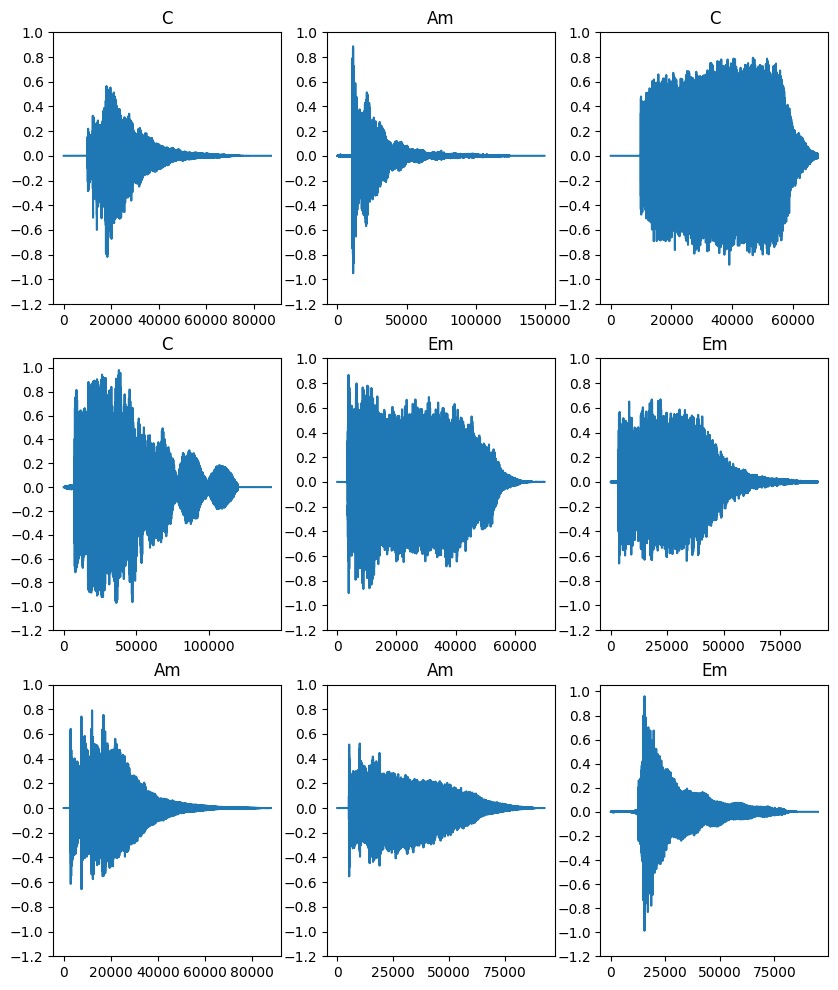

In [13]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [14]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=320, frame_step=32)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram

In [15]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: C
Waveform shape: (87116,)
Spectrogram shape: (491, 257, 1)
Audio playback


In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

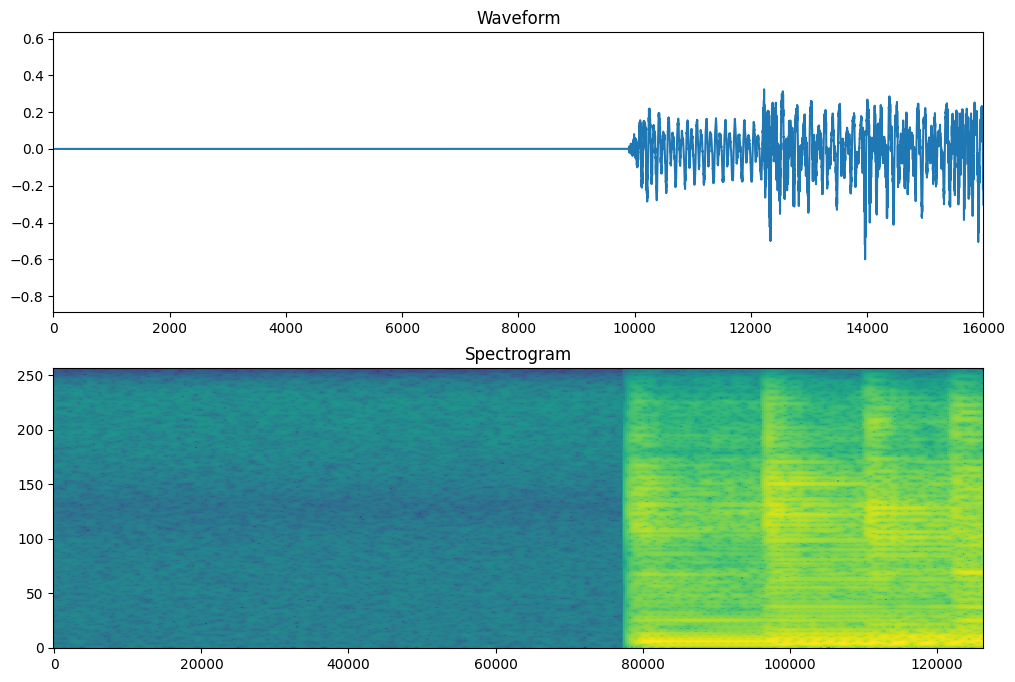

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [18]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == chords)
  return spectrogram, label_id

In [19]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

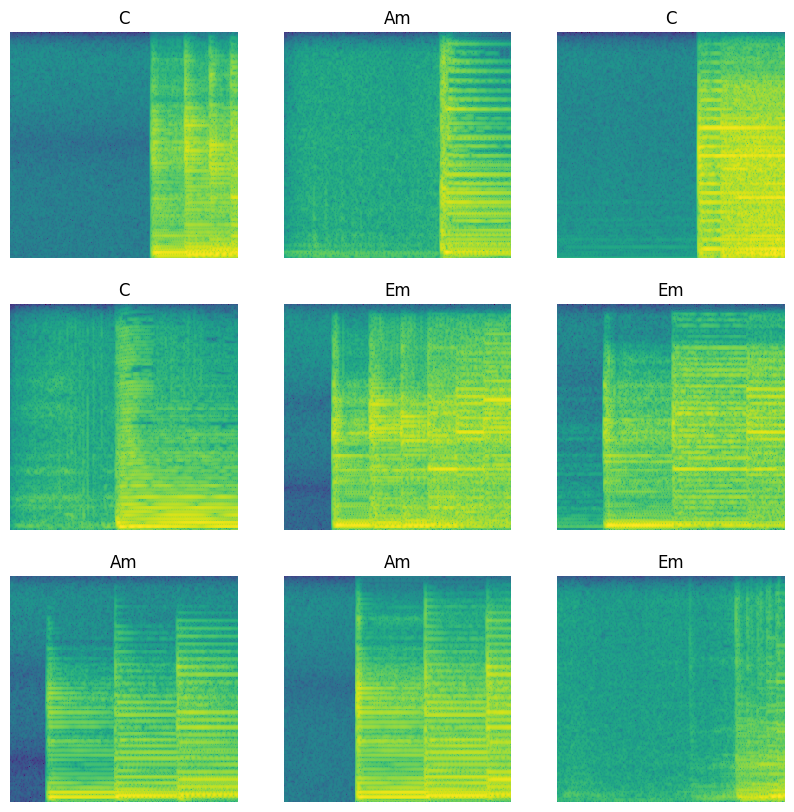

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(chords[label_id.numpy()])
  ax.axis('off')

plt.show()

In [21]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [23]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [24]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [25]:
for spectrogram, _ in spectrogram_ds.take(2):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(chords)


# Instantiate the `tf.keras.layers.Normalization` layer.
# norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
#     norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, activation='relu'),
       layers.MaxPooling2D(2),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_labels, activation='softmax'),
])
model.summary()

Input shape: (491, 257, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 489, 255, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 244, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 244, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 242, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 121, 62, 64)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [27]:
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
12/12 [==============================] - 49s 3s/step - loss: 4.5736 - accuracy: 0.3458 - val_loss: 0.9889 - val_accuracy: 0.5625
Epoch 2/100
12/12 [==============================] - 3s 262ms/step - loss: 0.8256 - accuracy: 0.6611 - val_loss: 0.6562 - val_accuracy: 0.7812
Epoch 3/100
12/12 [==============================] - 3s 257ms/step - loss: 0.5935 - accuracy: 0.7736 - val_loss: 0.3777 - val_accuracy: 0.8438
Epoch 4/100
12/12 [==============================] - 3s 258ms/step - loss: 0.4438 - accuracy: 0.8000 - val_loss: 0.3393 - val_accuracy: 0.8576
Epoch 5/100
12/12 [==============================] - 3s 268ms/step - loss: 0.3545 - accuracy: 0.8347 - val_loss: 0.2561 - val_accuracy: 0.8924
Epoch 6/100
12/12 [==============================] - 3s 264ms/step - loss: 0.2995 - accuracy: 0.8611 - val_loss: 0.2339 - val_accuracy: 0.9132
Epoch 7/100
12/12 [==============================] - 3s 261ms/step - loss: 0.2952 - accuracy: 0.8694 - val_loss: 0.2209 - val_accuracy: 0.9236
E

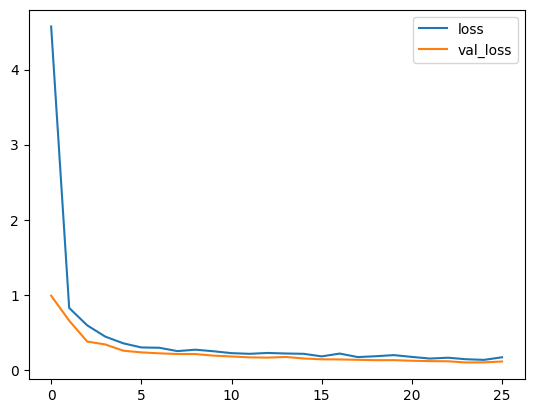

In [28]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [29]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [30]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 31%


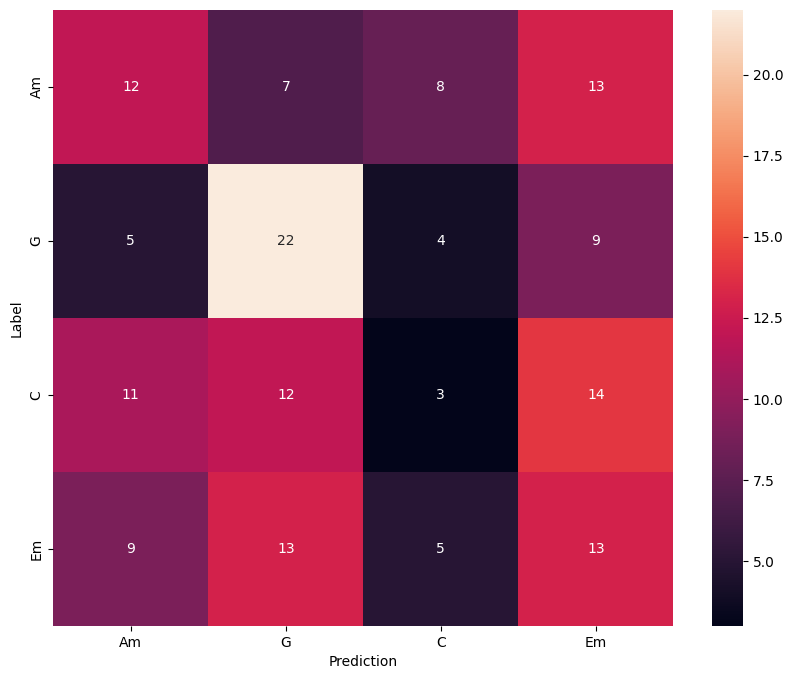

In [31]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=chords,
            yticklabels=chords,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file:  /content/drive/MyDrive/DataSet Guitar Chords/Test/Em/Em_Electric2_LInda_2.wav


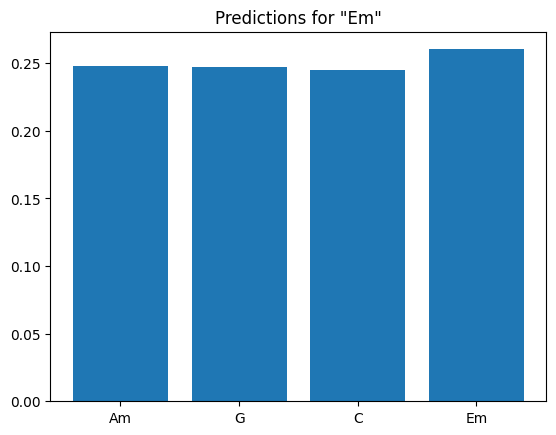

In [32]:
sample_file = test_files[135]
print('sample_file: ',sample_file)
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(chords, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{chords[label[0]]}"')
  plt.show()